<a href="https://colab.research.google.com/github/Hitansh-Shah/automatic-music-generator/blob/main/Final_UG_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
from google.colab import files

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import glob
import math
from tqdm import tqdm
import numpy as np
import tensorflow as tf
from music21 import converter, note, chord, stream, instrument, midi
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, GRU
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.utils import Sequence

In [ ]:
filepath = "/content/gdrive/MyDrive/ug-data/all_midi_files/"
all_midi_files = glob.glob(filepath + '/*.mid', recursive=True)
classical_path = "/content/gdrive/MyDrive/ug-data/classical/"
classical_midi_files = glob.glob(classical_path + '/*.mid', recursive=True)

In [ ]:
def encode_midi(midi_file, transpose=0):

  midi_file = converter.parse(midi_file)
  lowest_note = 21
  highest_note = 108

  total_time_steps = int(midi_file.highestTime * 4)

  highest_time = 0

  for element in midi_file.flatten().notesAndRests:
      if isinstance(element, note.Note):
          # Single note
          note_pitch = element.pitch.midi - lowest_note + transpose
          if(note_pitch < 0 or note_pitch > 87):
            continue

          highest_time = max(highest_time, int((element.offset + element.duration.quarterLength) * 4))

      elif isinstance(element, chord.Chord):
          # Chord (multiple notes)
          for note_obj in element:
              note_pitch = note_obj.pitch.midi - lowest_note + transpose
              if(note_pitch < 0 or note_pitch > 87):
                continue
              highest_time = max(highest_time, int((element.offset + element.duration.quarterLength) * 4))

  piano_roll = np.zeros((highest_note - lowest_note + 1, int(highest_time)), dtype=int)
  piano_roll = piano_roll.astype(np.int8)

  # piano_roll = np.zeros((highest_note - lowest_note + 1, total_time_steps), dtype=int)


  for element in midi_file.flatten().notesAndRests:
      start_time = int(element.offset * 4)
      end_time = int((element.offset + element.duration.quarterLength) * 4)

      if isinstance(element, note.Note):
          # Single note
          note_pitch = element.pitch.midi - lowest_note + transpose
          if(note_pitch < 0 or note_pitch > 87):
            continue
          note_velocity = element.volume.velocity

          for t in range(start_time, end_time):
              piano_roll[note_pitch, t] = note_velocity

      elif isinstance(element, chord.Chord):
          # Chord (multiple notes)
          for note_obj in element:
              note_pitch = note_obj.pitch.midi - lowest_note + transpose
              note_velocity = note_obj.volume.velocity
              if(note_pitch < 0 or note_pitch > 87):
                continue

              for t in range(start_time, end_time):
                  piano_roll[note_pitch, t] = note_velocity

  # print(piano_roll.shape[1])
  return piano_roll



In [ ]:
def decode_midi(piano_roll):

  lowest_note = 21
  highest_note = 108
  num_notes = highest_note - lowest_note + 1

  midi_stream = stream.Stream()
  active_notes = {}

  for i in range(piano_roll.shape[1]):
      for j in range(piano_roll.shape[0]):
          velocity = piano_roll[j][i]
          note_pitch = j
          time_step = i
          if velocity > 0:
              midi_note = note_pitch + lowest_note

              if midi_note not in active_notes:
                  note_or_chord = note.Note(midi_note)
                  note_or_chord.duration.quarterLength = 0.25
                  note_or_chord.volume.velocity = velocity
                  active_notes[midi_note] = note_or_chord

                  midi_stream.insert(time_step / 4, note_or_chord)
              else:
                  active_note = active_notes[midi_note]
                  active_note.duration.quarterLength += 0.25
                  active_note.volume.velocity = max(active_note.volume.velocity, velocity)

      ended_notes = [midi_note for midi_note, active_note in active_notes.items() if active_note.offset + active_note.duration.quarterLength <= time_step / 4]
      for midi_note in ended_notes:
          del active_notes[midi_note]

  piano = instrument.Piano()
  midi_stream.insert(0, piano)

  midi_stream.write('midi', 'output_piano.mid')


In [ ]:
decode_midi(encode_midi(classical_midi_files[5]))

In [ ]:
classical_midi_files

['/content/gdrive/MyDrive/ug-data/classical/mz_311_1.mid',
 '/content/gdrive/MyDrive/ug-data/classical/mz_311_3.mid',
 '/content/gdrive/MyDrive/ug-data/classical/mz_330_1.mid',
 '/content/gdrive/MyDrive/ug-data/classical/mz_330_3.mid',
 '/content/gdrive/MyDrive/ug-data/classical/mz_331_2.mid',
 '/content/gdrive/MyDrive/ug-data/classical/mz_331_3.mid',
 '/content/gdrive/MyDrive/ug-data/classical/mz_332_1.mid',
 '/content/gdrive/MyDrive/ug-data/classical/mz_333_1.mid',
 '/content/gdrive/MyDrive/ug-data/classical/mz_545_1.mid',
 '/content/gdrive/MyDrive/ug-data/classical/mz_570_1.mid',
 '/content/gdrive/MyDrive/ug-data/classical/mz_570_3.mid',
 '/content/gdrive/MyDrive/ug-data/classical/mz_333_3.mid']

In [ ]:
encoded_midis = []

for midi_file in tqdm(classical_midi_files):
    encoded_midi = encode_midi(midi_file)
    encoded_midis.append(encoded_midi)

prev_encoded_midis = encoded_midis

  0%|          | 0/12 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2006 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(
 17%|█▋        | 2/12 [00:15<01:20,  8.03s/it]/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 1997 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(
 33%|███▎      | 4/12 [00:31<01:05,  8.16s/it]/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2005 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(
 67%|██████▋

In [ ]:
encoded_midis = np.concatenate(encoded_midis, axis = 1)

In [ ]:
encoded_midis.shape

(88, 39342)

In [ ]:
encoded_midis = encoded_midis.transpose()

In [ ]:
encoded_midis.shape

(39342, 88)

In [ ]:
input_sequences = []
output_sequences = []

seq_len = 16

for i in range(encoded_midis.shape[0] - seq_len):
  input_sequences.append(encoded_midis[i:i+seq_len])
  output_sequences.append(encoded_midis[i+seq_len])


In [ ]:
input_sequences = []
output_sequences = []

seq_len = 16


for midi_file in tqdm(classical_midi_files):
  piano_roll = encode_midi(midi_file)
  piano_roll = np.array(piano_roll)
  piano_roll = piano_roll.transpose()
  for i in range(piano_roll.shape[0] - seq_len):
    input_sequences.append(piano_roll[i: i+seq_len])
    output_sequences.append(piano_roll[i+seq_len])


  0%|          | 0/12 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2006 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(
 17%|█▋        | 2/12 [00:14<01:14,  7.46s/it]/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 1997 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(
 33%|███▎      | 4/12 [00:31<01:02,  7.81s/it]/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2005 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(
 67%|██████▋

In [ ]:
print(input_sequences[0].shape)
print(output_sequences[0].shape)

(16, 88)
(88,)


In [ ]:
len(input_sequences)

39150

In [ ]:
temp_input = input_sequences
temp_output = output_sequences

input_sequences = np.array(input_sequences)
output_sequences = np.array(output_sequences)

In [ ]:
output_sequences.shape
input_sequences.shape

(39150, 16, 88)

In [ ]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(
    input_sequences, output_sequences, test_size=0.1, random_state=42
)

In [ ]:
# input_shape = (1, 16, 88)
# output_shape = (1, 88)


input_shape = (1, 16, 88)
output_shape = (1, 1, 88)

In [ ]:
# parameters

optimizer = RMSprop(learning_rate=0.001)
loss = 'mean_squared_error'
batch_size = 32
epochs = 64

In [ ]:
# Building Single layer LSTM Model

single_lstm_model = Sequential()
single_lstm_model.add(LSTM(512, input_shape=input_shape[1:]))
single_lstm_model.add(Dense(88, activation='linear'))

single_lstm_model.compile(optimizer=RMSprop(learning_rate=0.0001), loss=loss, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


In [ ]:
single_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 512)               1230848   
                                                                 
 dense (Dense)               (None, 88)                45144     
                                                                 
Total params: 1275992 (4.87 MB)
Trainable params: 1275992 (4.87 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# add support for checkpoints

import math
n_batches = X_train.shape[0]/batch_size
n_batches = math.ceil(n_batches)


checkpoint_path = "/content/gdrive/MyDrive/ug_checkpoints/single_layer_lstm/training_2/cp-{epoch:04d}.ckpt"

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=4*n_batches)


In [ ]:
single_lstm_model.save_weights(checkpoint_path.format(epoch=0))

In [ ]:
import os
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint_dir

'/content/gdrive/MyDrive/ug_checkpoints/single_layer_lstm/training_2'

In [ ]:
# train single layer lstm model

single_lstm_model.fit(X_train, y_train,
                      epochs=250,
                      batch_size=batch_size,
                      # callbacks=[cp_callback],
                      validation_data=(X_test, y_test))

Epoch 1/250
1102/1102 [==============================] - 16s 7ms/step - loss: 57.6255 - accuracy: 0.2316 - precision: 0.0537 - recall: 0.9304 - val_loss: 53.5884 - val_accuracy: 0.2669 - val_precision: 0.0582 - val_recall: 0.9861
Epoch 2/250
1102/1102 [==============================] - 7s 7ms/step - loss: 51.7504 - accuracy: 0.2912 - precision: 0.0622 - recall: 0.9869 - val_loss: 50.5129 - val_accuracy: 0.2794 - val_precision: 0.0654 - val_recall: 0.9862
Epoch 3/250
1102/1102 [==============================] - 6s 6ms/step - loss: 49.2248 - accuracy: 0.3058 - precision: 0.0684 - recall: 0.9882 - val_loss: 48.7807 - val_accuracy: 0.2973 - val_precision: 0.0713 - val_recall: 0.9855
Epoch 4/250
1102/1102 [==============================] - 7s 6ms/step - loss: 47.5629 - accuracy: 0.3168 - precision: 0.0723 - recall: 0.9894 - val_loss: 47.5624 - val_accuracy: 0.3017 - val_precision: 0.0733 - val_recall: 0.9845
Epoch 5/250
1102/1102 [==============================] - 6s 6ms/step - loss: 46.277

In [ ]:
single_lstm_model.save('/content/gdrive/MyDrive/ug_checkpoints/saved_model/single_lstm_new')

In [ ]:
# Building Single layer GRU Model

single_gru_model = Sequential()
single_gru_model.add(GRU(512, input_shape=input_shape[1:]))
single_gru_model.add(Dense(88, activation='linear'))
single_gru_model.compile(optimizer=RMSprop(learning_rate=0.0001), loss=loss, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
single_gru_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 512)               924672    
                                                                 
 dense_2 (Dense)             (None, 88)                45144     
                                                                 
Total params: 969816 (3.70 MB)
Trainable params: 969816 (3.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# train single layer gru model

single_gru_history = single_gru_model.fit(X_train, y_train,
                      epochs=250,
                      batch_size=batch_size,
                      validation_data=(X_test, y_test))

Epoch 1/250
1102/1102 [==============================] - 9s 6ms/step - loss: 56.3132 - accuracy: 0.2672 - precision_2: 0.0515 - recall_2: 0.9415 - val_loss: 52.0587 - val_accuracy: 0.2976 - val_precision_2: 0.0575 - val_recall_2: 0.9823
Epoch 2/250
1102/1102 [==============================] - 7s 6ms/step - loss: 50.2574 - accuracy: 0.3153 - precision_2: 0.0620 - recall_2: 0.9825 - val_loss: 49.1647 - val_accuracy: 0.3070 - val_precision_2: 0.0650 - val_recall_2: 0.9821
Epoch 3/250
1102/1102 [==============================] - 9s 8ms/step - loss: 47.9716 - accuracy: 0.3233 - precision_2: 0.0682 - recall_2: 0.9841 - val_loss: 47.6790 - val_accuracy: 0.3114 - val_precision_2: 0.0703 - val_recall_2: 0.9819
Epoch 4/250
1102/1102 [==============================] - 7s 6ms/step - loss: 46.5269 - accuracy: 0.3290 - precision_2: 0.0720 - recall_2: 0.9861 - val_loss: 46.6690 - val_accuracy: 0.3119 - val_precision_2: 0.0726 - val_recall_2: 0.9808
Epoch 5/250
1102/1102 [=============================

In [ ]:
single_gru_model.save('/content/gdrive/MyDrive/ug_checkpoints/saved_model/single_gru_new')

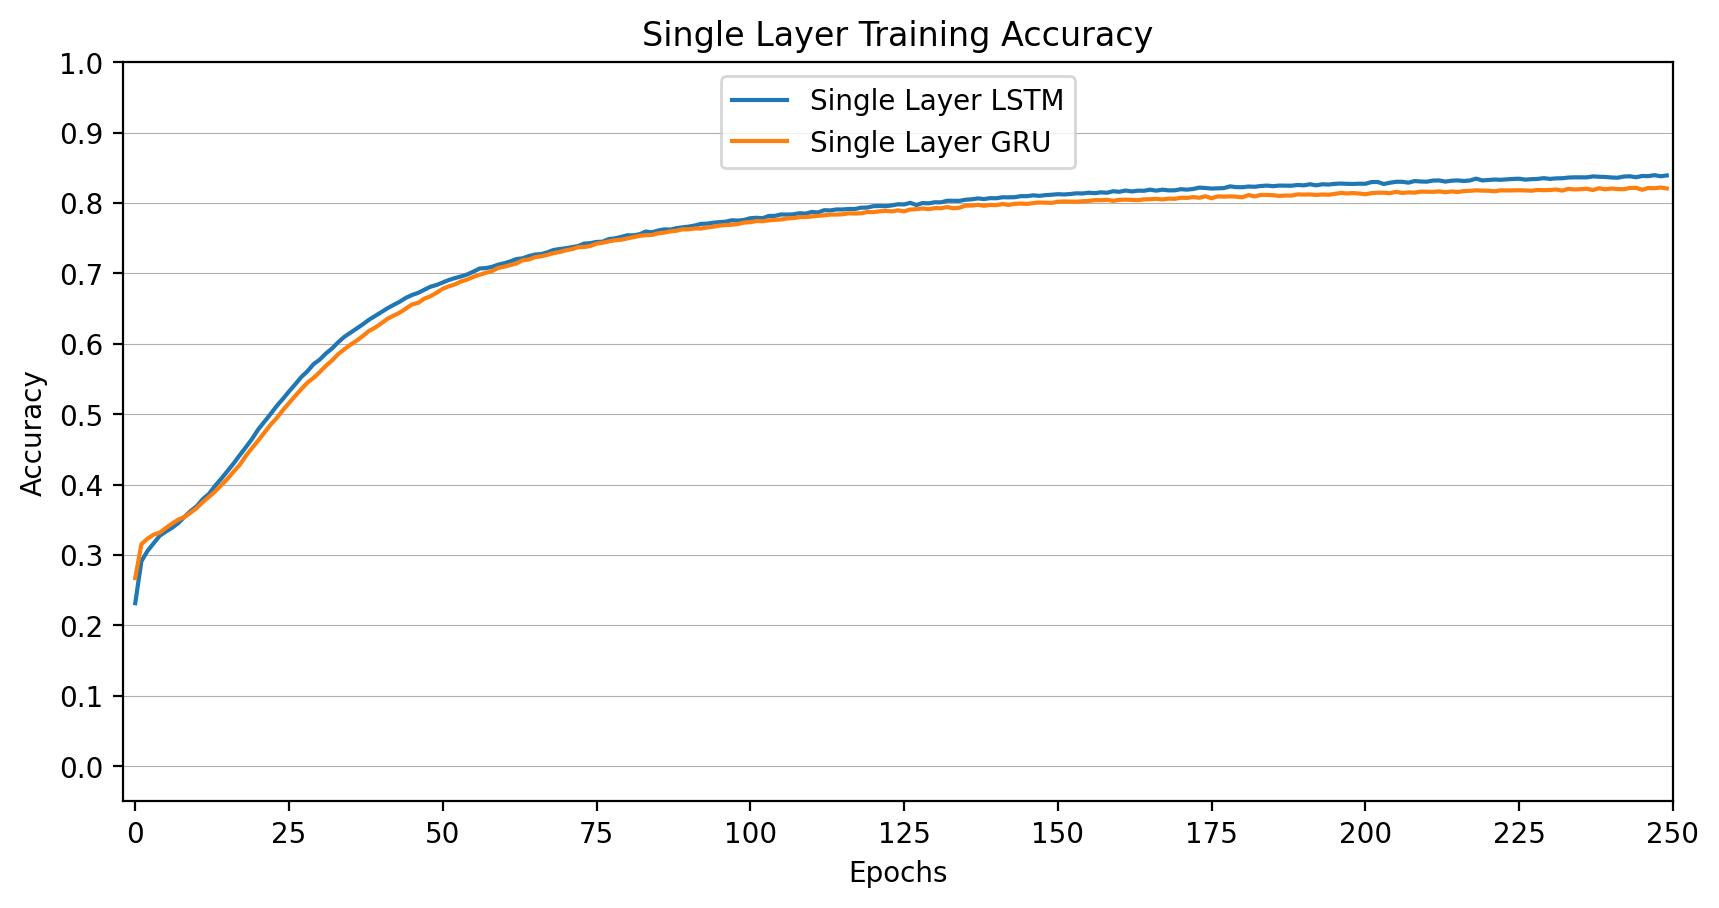

In [ ]:
plt.figure().set_figwidth(10)
plt.grid(axis = 'y', linewidth=0.4)
plt.plot(single_lstm_model.history.history['accuracy'])
plt.plot(single_gru_model.history.history['accuracy'])
plt.ylim([-0.05, 1])
plt.xlim([-2, 250])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(np.arange(0, 251,25))
plt.title('Single Layer Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Single Layer LSTM', 'Single Layer GRU'], loc='upper center')
plt.show()

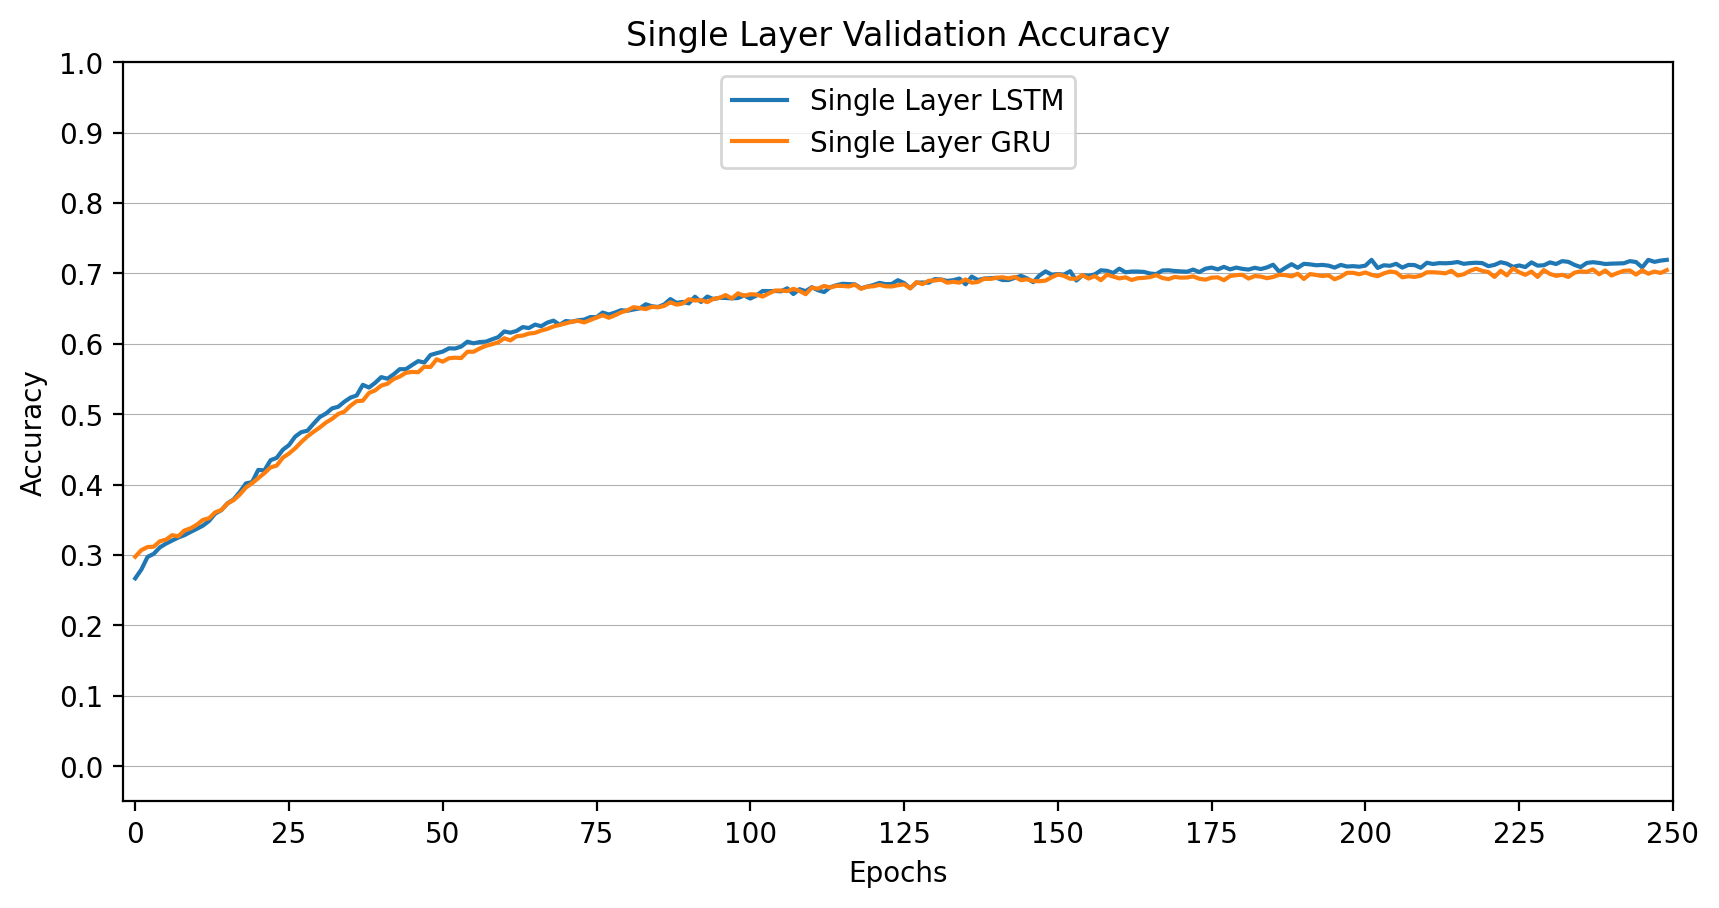

In [ ]:
plt.figure().set_figwidth(10)
plt.grid(axis = 'y', linewidth=0.4)
plt.plot(single_lstm_model.history.history['val_accuracy'])
plt.plot(single_gru_model.history.history['val_accuracy'])
plt.ylim([-0.05, 1])
plt.xlim([-2, 250])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(np.arange(0, 251,25))
plt.title('Single Layer Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Single Layer LSTM', 'Single Layer GRU'], loc='upper center')
plt.show()

In [ ]:
double_lstm_model = Sequential()

double_lstm_model.add(LSTM(512, input_shape=input_shape[1:], return_sequences=True))
double_lstm_model.add(Dropout(0.1))
double_lstm_model.add(LSTM(512))
double_lstm_model.add(Dropout(0.1))
double_lstm_model.add(Dense(88, activation='linear'))

double_lstm_model.compile(optimizer=RMSprop(learning_rate=0.0001), loss=loss, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
double_lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 16, 512)           1230848   
                                                                 
 dropout (Dropout)           (None, 16, 512)           0         
                                                                 
 lstm_2 (LSTM)               (None, 512)               2099200   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 88)                45144     
                                                                 
Total params: 3375192 (12.88 MB)
Trainable params: 3375192 (12.88 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
double_lstm_history = double_lstm_model.fit(X_train, y_train,
                      epochs=250,
                      batch_size=batch_size,
                      validation_data=(X_test, y_test))

Epoch 1/250
1102/1102 [==============================] - 17s 11ms/step - loss: 57.1952 - accuracy: 0.1770 - precision_3: 0.0531 - recall_3: 0.9671 - val_loss: 54.1573 - val_accuracy: 0.2250 - val_precision_3: 0.0616 - val_recall_3: 0.9880
Epoch 2/250
1102/1102 [==============================] - 11s 10ms/step - loss: 52.3109 - accuracy: 0.2548 - precision_3: 0.0615 - recall_3: 0.9896 - val_loss: 51.0075 - val_accuracy: 0.2613 - val_precision_3: 0.0664 - val_recall_3: 0.9909
Epoch 3/250
1102/1102 [==============================] - 11s 10ms/step - loss: 49.4015 - accuracy: 0.2904 - precision_3: 0.0680 - recall_3: 0.9900 - val_loss: 48.8693 - val_accuracy: 0.2879 - val_precision_3: 0.0745 - val_recall_3: 0.9850
Epoch 4/250
1102/1102 [==============================] - 12s 11ms/step - loss: 47.1505 - accuracy: 0.3183 - precision_3: 0.0727 - recall_3: 0.9904 - val_loss: 47.1361 - val_accuracy: 0.3045 - val_precision_3: 0.0731 - val_recall_3: 0.9889
Epoch 5/250
1102/1102 [=====================

In [ ]:
double_lstm_model.save('/content/gdrive/MyDrive/ug_checkpoints/saved_model/double_lstm_new')

In [ ]:
double_gru_model = Sequential()

double_gru_model.add(GRU(512, input_shape=input_shape[1:], return_sequences=True))
double_gru_model.add(Dropout(0.1))
double_gru_model.add(GRU(512))
double_gru_model.add(Dropout(0.1))
double_gru_model.add(Dense(88, activation='linear'))

double_gru_model.compile(optimizer=RMSprop(learning_rate=0.0001), loss=loss, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
double_gru_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 16, 512)           924672    
                                                                 
 dropout_2 (Dropout)         (None, 16, 512)           0         
                                                                 
 gru_3 (GRU)                 (None, 512)               1575936   
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 88)                45144     
                                                                 
Total params: 2545752 (9.71 MB)
Trainable params: 2545752 (9.71 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
double_gru_history = double_gru_model.fit(X_train, y_train,
                      epochs=250,
                      batch_size=batch_size,
                      validation_data=(X_test, y_test))

Epoch 1/250
1102/1102 [==============================] - 18s 10ms/step - loss: 54.7545 - accuracy: 0.2632 - precision_4: 0.0551 - recall_4: 0.9664 - val_loss: 51.0153 - val_accuracy: 0.2881 - val_precision_4: 0.0649 - val_recall_4: 0.9831
Epoch 2/250
1102/1102 [==============================] - 9s 8ms/step - loss: 49.5253 - accuracy: 0.3103 - precision_4: 0.0645 - recall_4: 0.9803 - val_loss: 48.5235 - val_accuracy: 0.3075 - val_precision_4: 0.0711 - val_recall_4: 0.9838
Epoch 3/250
1102/1102 [==============================] - 10s 9ms/step - loss: 47.3180 - accuracy: 0.3252 - precision_4: 0.0705 - recall_4: 0.9805 - val_loss: 46.9455 - val_accuracy: 0.3157 - val_precision_4: 0.0754 - val_recall_4: 0.9785
Epoch 4/250
1102/1102 [==============================] - 10s 9ms/step - loss: 45.6242 - accuracy: 0.3367 - precision_4: 0.0742 - recall_4: 0.9837 - val_loss: 45.6887 - val_accuracy: 0.3226 - val_precision_4: 0.0734 - val_recall_4: 0.9845
Epoch 5/250
1102/1102 [=========================

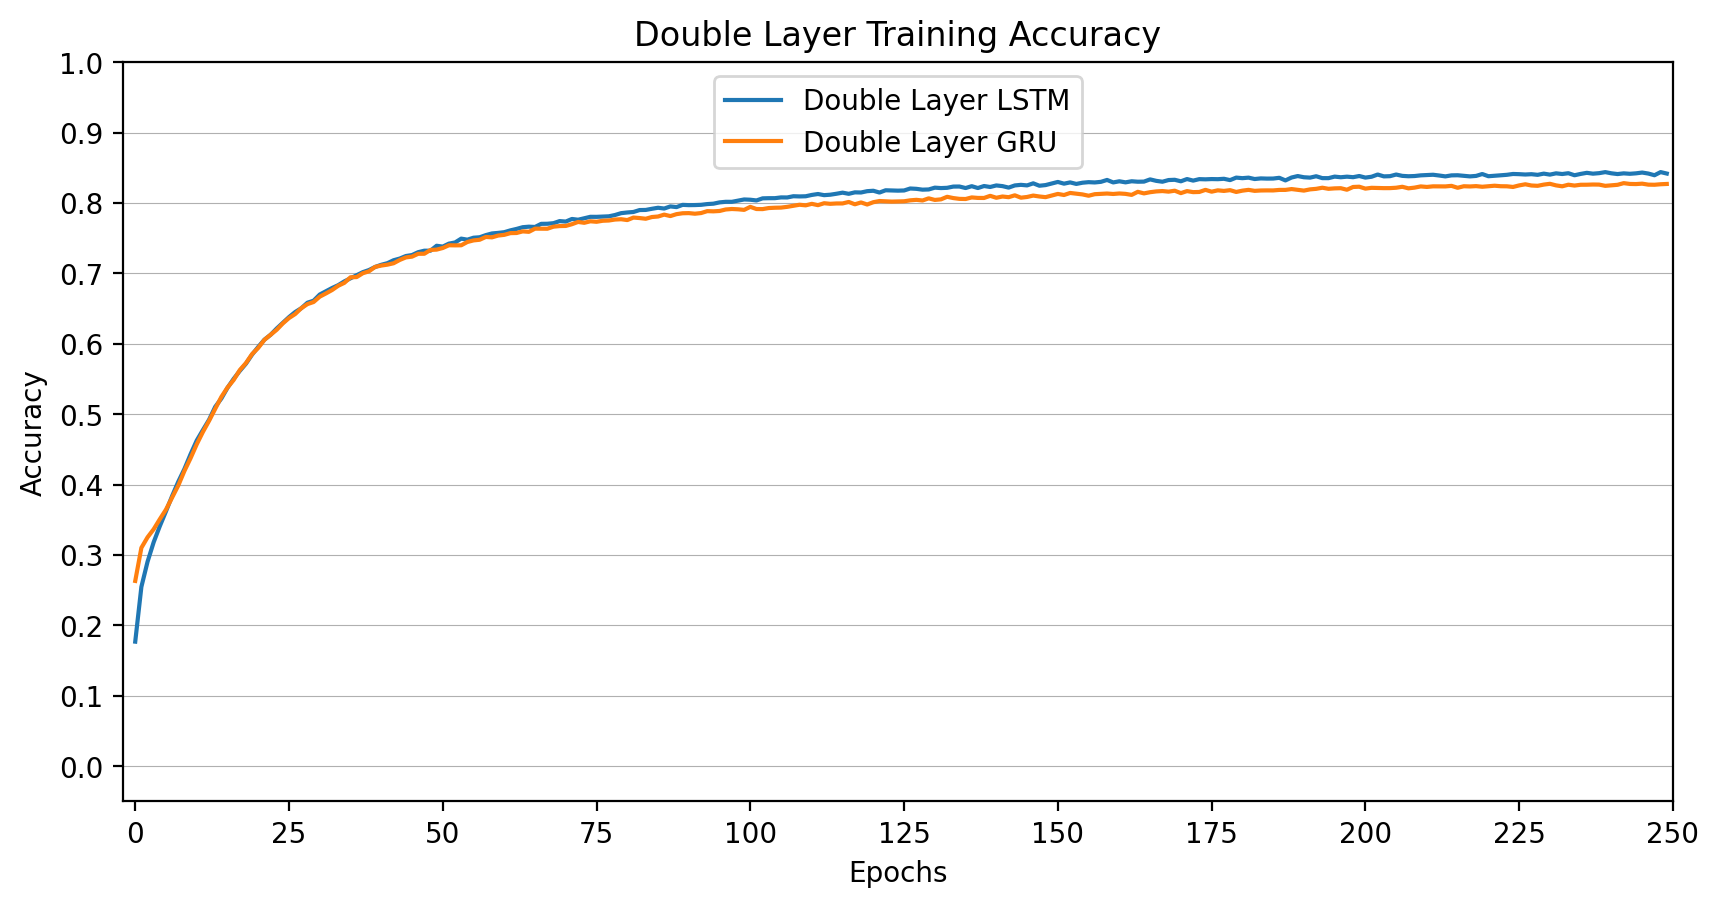

In [ ]:
plt.figure().set_figwidth(10)
plt.grid(axis = 'y', linewidth=0.4)
plt.plot(double_lstm_model.history.history['accuracy'])
plt.plot(double_gru_model.history.history['accuracy'])
plt.ylim([-0.05, 1])
plt.xlim([-2, 250])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(np.arange(0, 251,25))
plt.title('Double Layer Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Double Layer LSTM', 'Double Layer GRU'], loc='upper center')
plt.show()

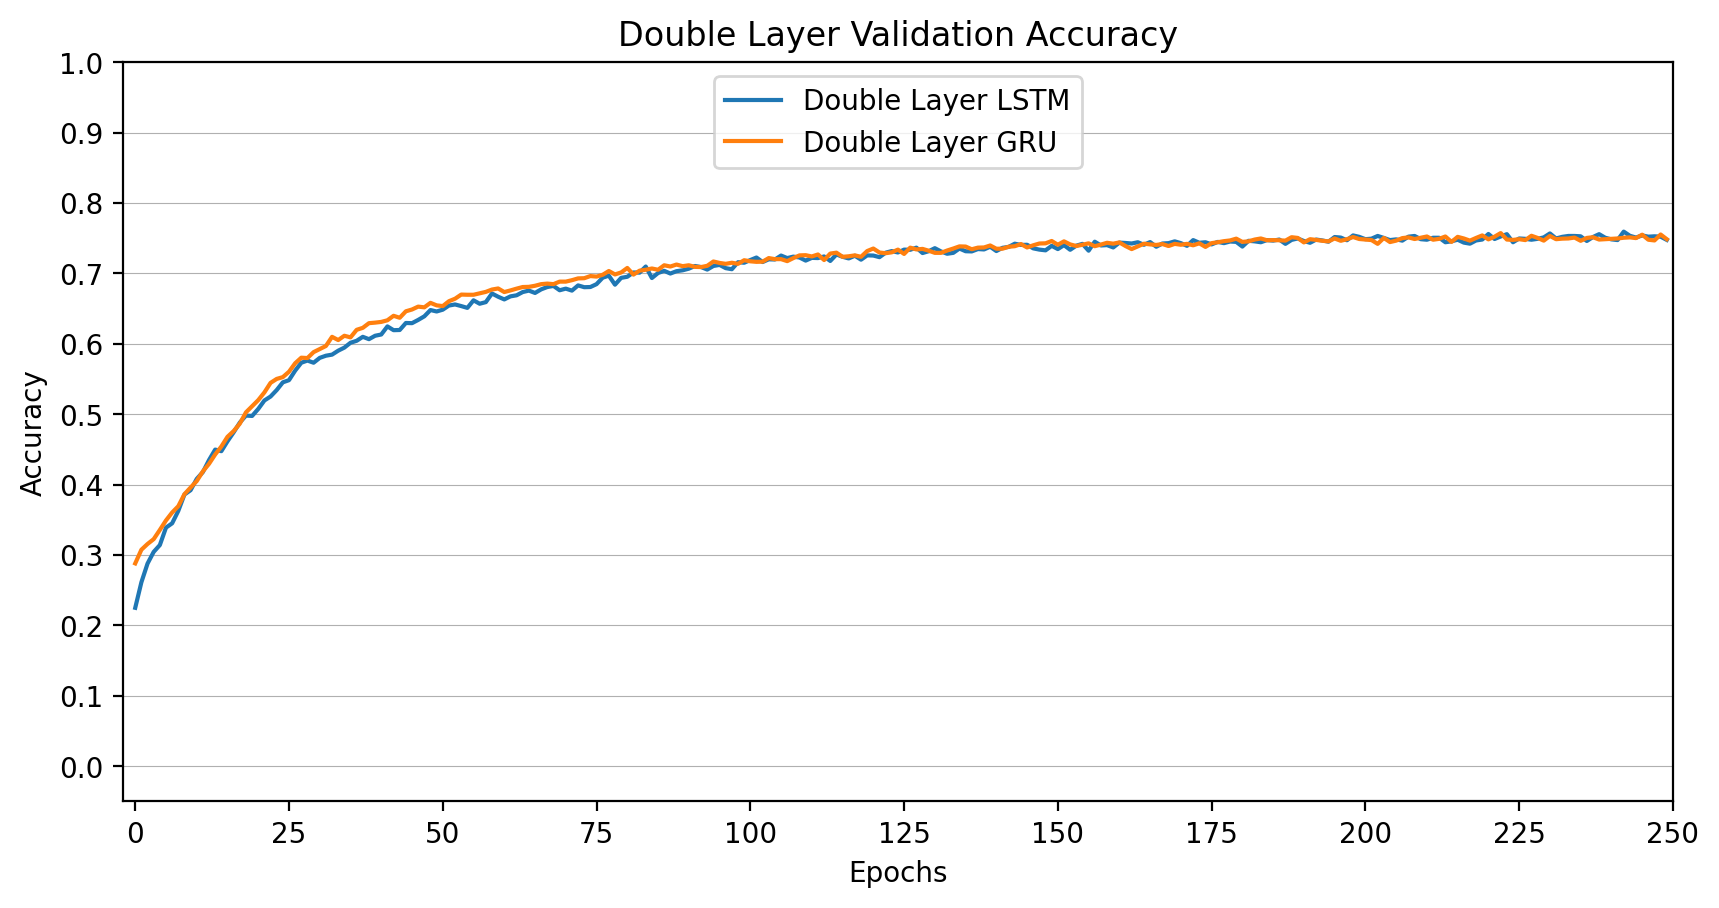

In [ ]:
plt.figure().set_figwidth(10)
plt.grid(axis = 'y', linewidth=0.4)
plt.plot(double_lstm_model.history.history['val_accuracy'])
plt.plot(double_gru_model.history.history['val_accuracy'])
plt.ylim([-0.05, 1])
plt.xlim([-2, 250])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(np.arange(0, 251,25))
plt.title('Double Layer Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Double Layer LSTM', 'Double Layer GRU'], loc='upper center')
plt.show()

In [ ]:
double_gru_model.save('/content/gdrive/MyDrive/ug_checkpoints/saved_model/double_gru_new')

# Old Single Layer Accuracy

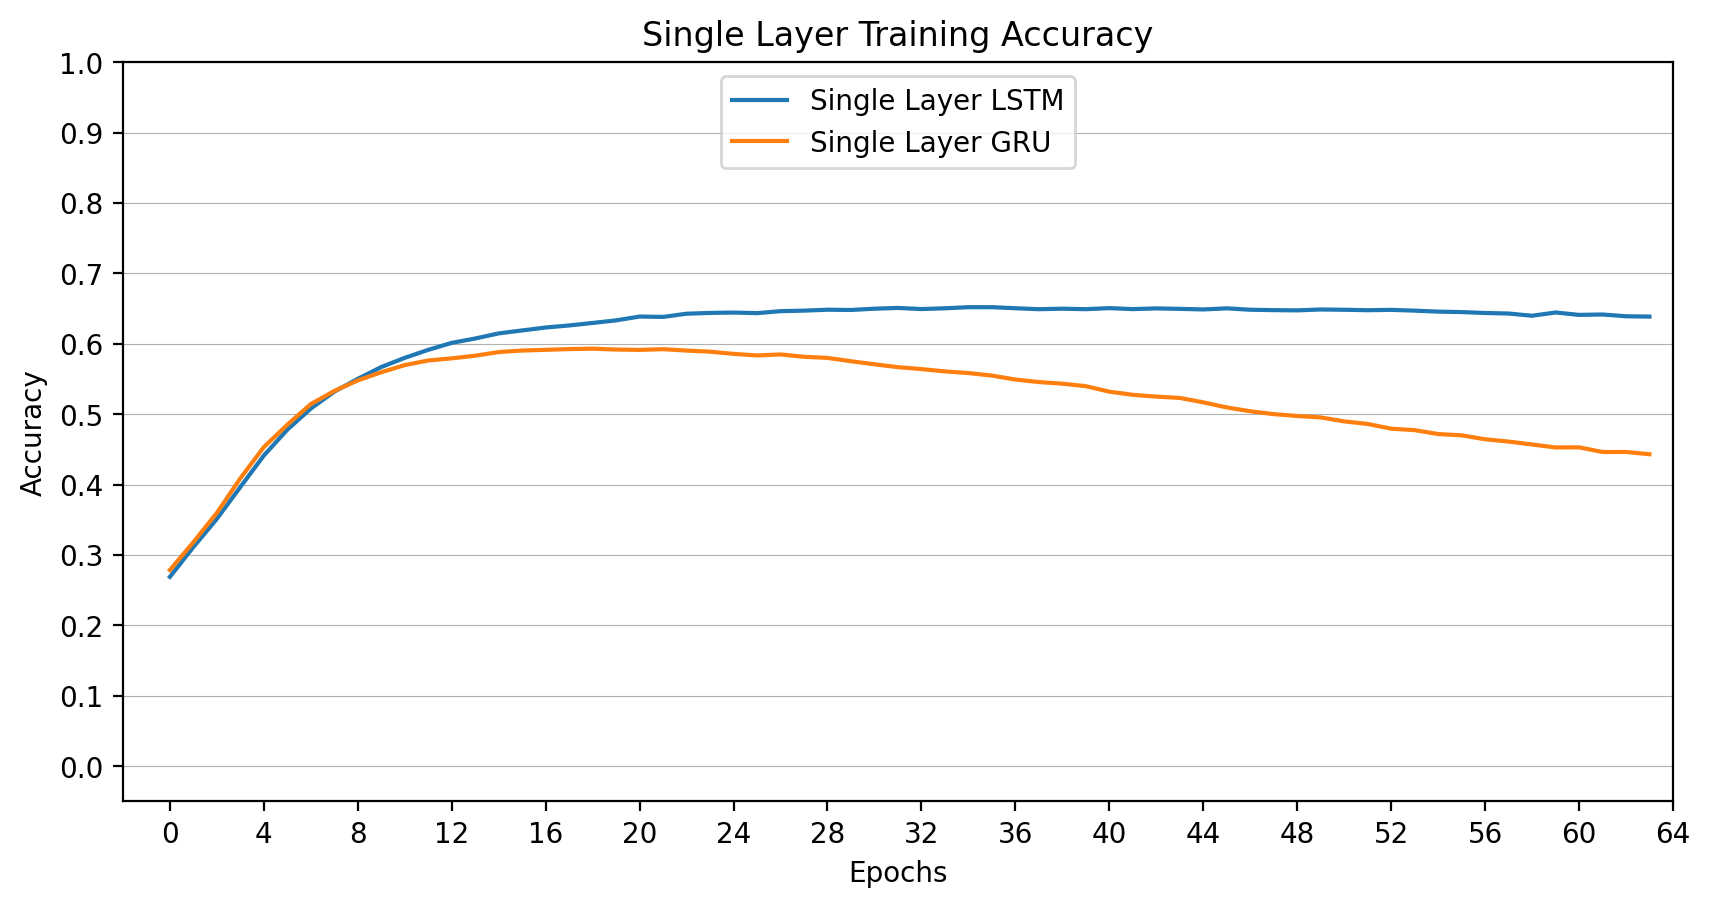

In [ ]:
plt.figure().set_figwidth(10)
plt.grid(axis = 'y', linewidth=0.4)
plt.plot(single_lstm_model.history.history['accuracy'])
plt.plot(single_gru_model.history.history['accuracy'])
plt.ylim([-0.05, 1])
plt.xlim([-2, 64])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(np.arange(0, 65, 4))
plt.title('Single Layer Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Single Layer LSTM', 'Single Layer GRU'], loc='upper center')
plt.show()

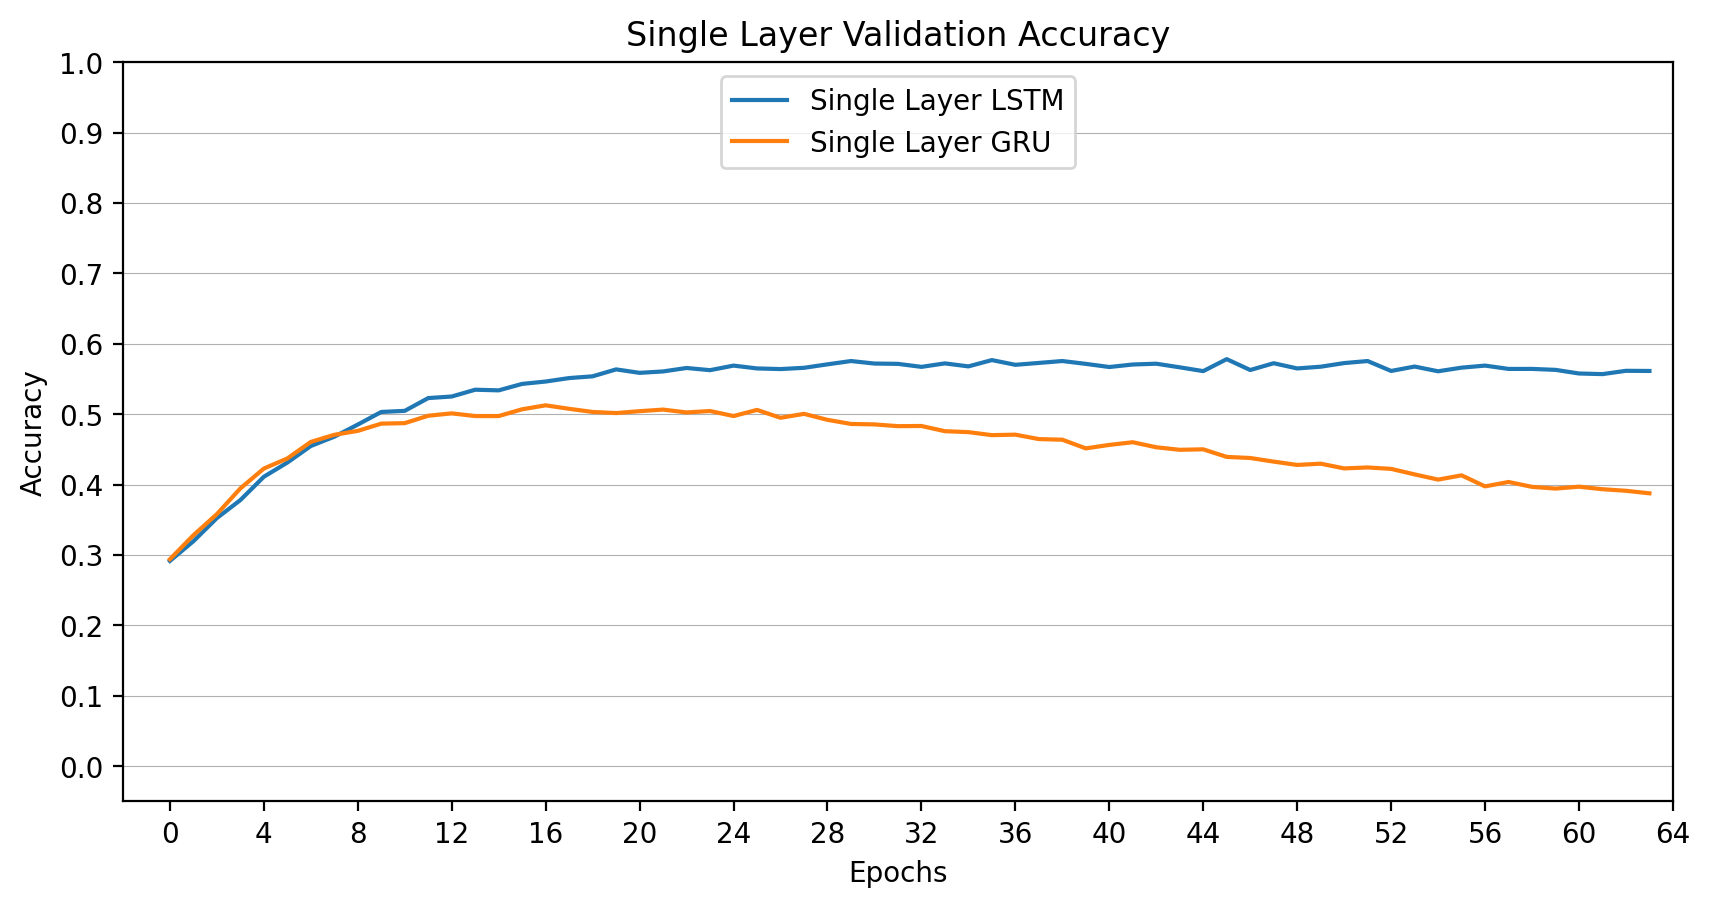

In [ ]:
plt.figure().set_figwidth(10)
plt.grid(axis = 'y', linewidth=0.4)
plt.plot(single_lstm_model.history.history['val_accuracy'])
plt.plot(single_gru_model.history.history['val_accuracy'])
plt.ylim([-0.05, 1])
plt.xlim([-2, 64])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(np.arange(0, 65, 4))
plt.title('Single Layer Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Single Layer LSTM', 'Single Layer GRU'], loc='upper center')
plt.show()

# Old Double Layer Accuracy

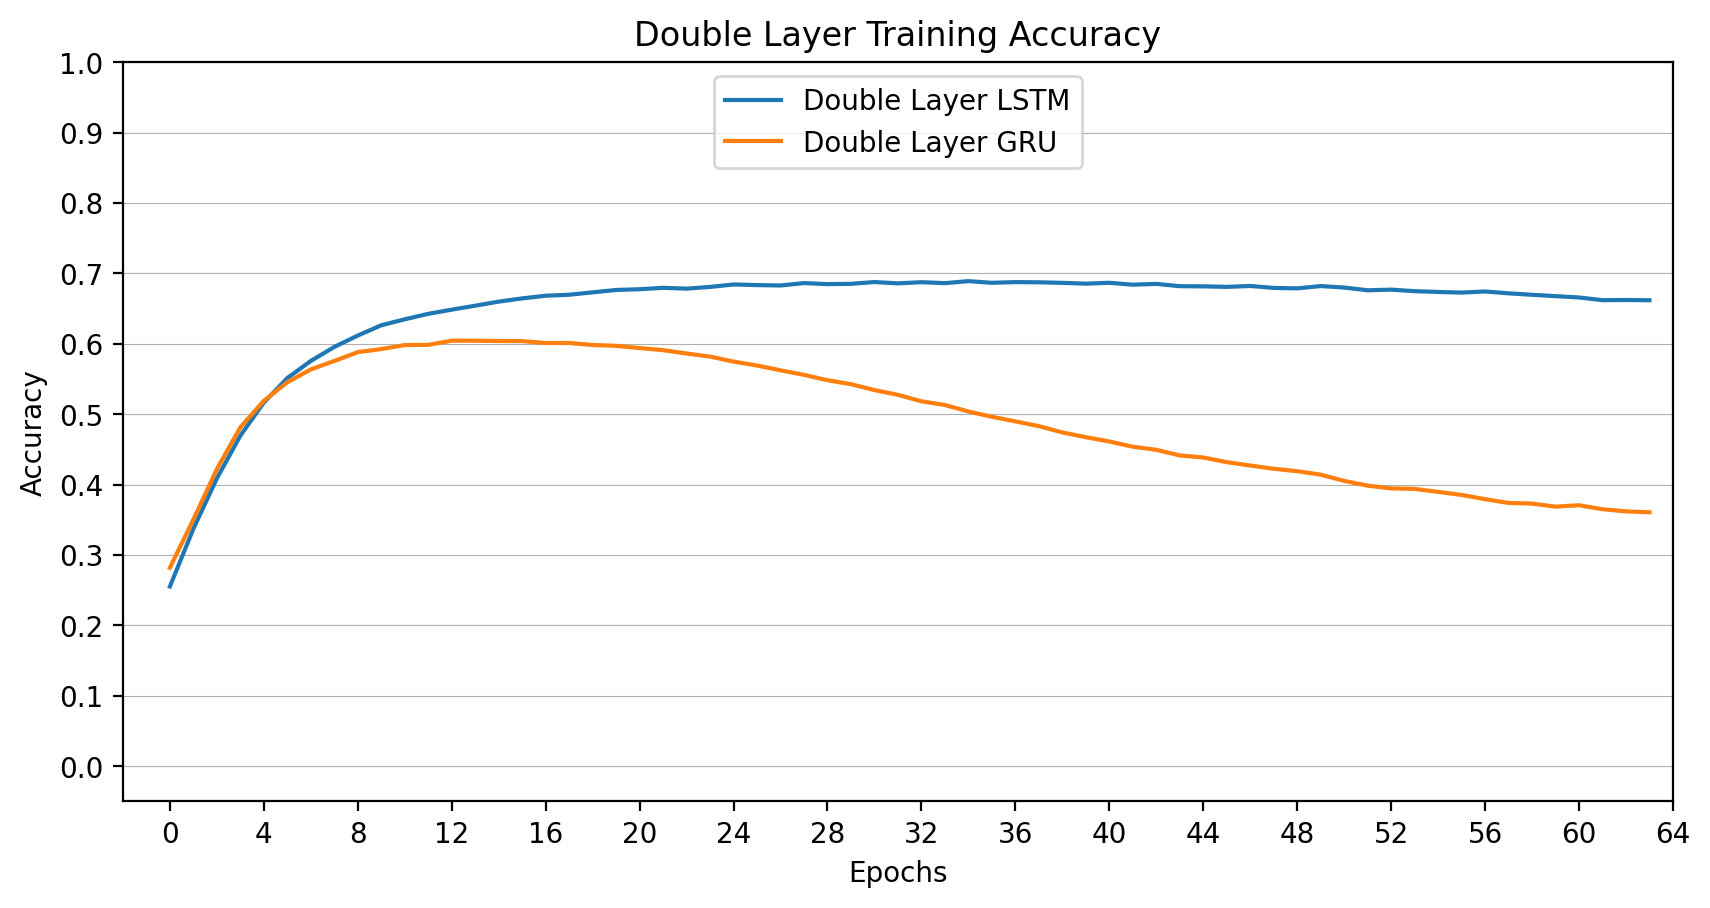

In [ ]:
plt.figure().set_figwidth(10)
plt.grid(axis = 'y', linewidth=0.4)
plt.plot(double_lstm_model.history.history['accuracy'])
plt.plot(double_gru_model.history.history['accuracy'])
plt.ylim([-0.05, 1])
plt.xlim([-2, 64])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(np.arange(0, 65, 4))
plt.title('Double Layer Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Double Layer LSTM', 'Double Layer GRU'], loc='upper center')
plt.show()

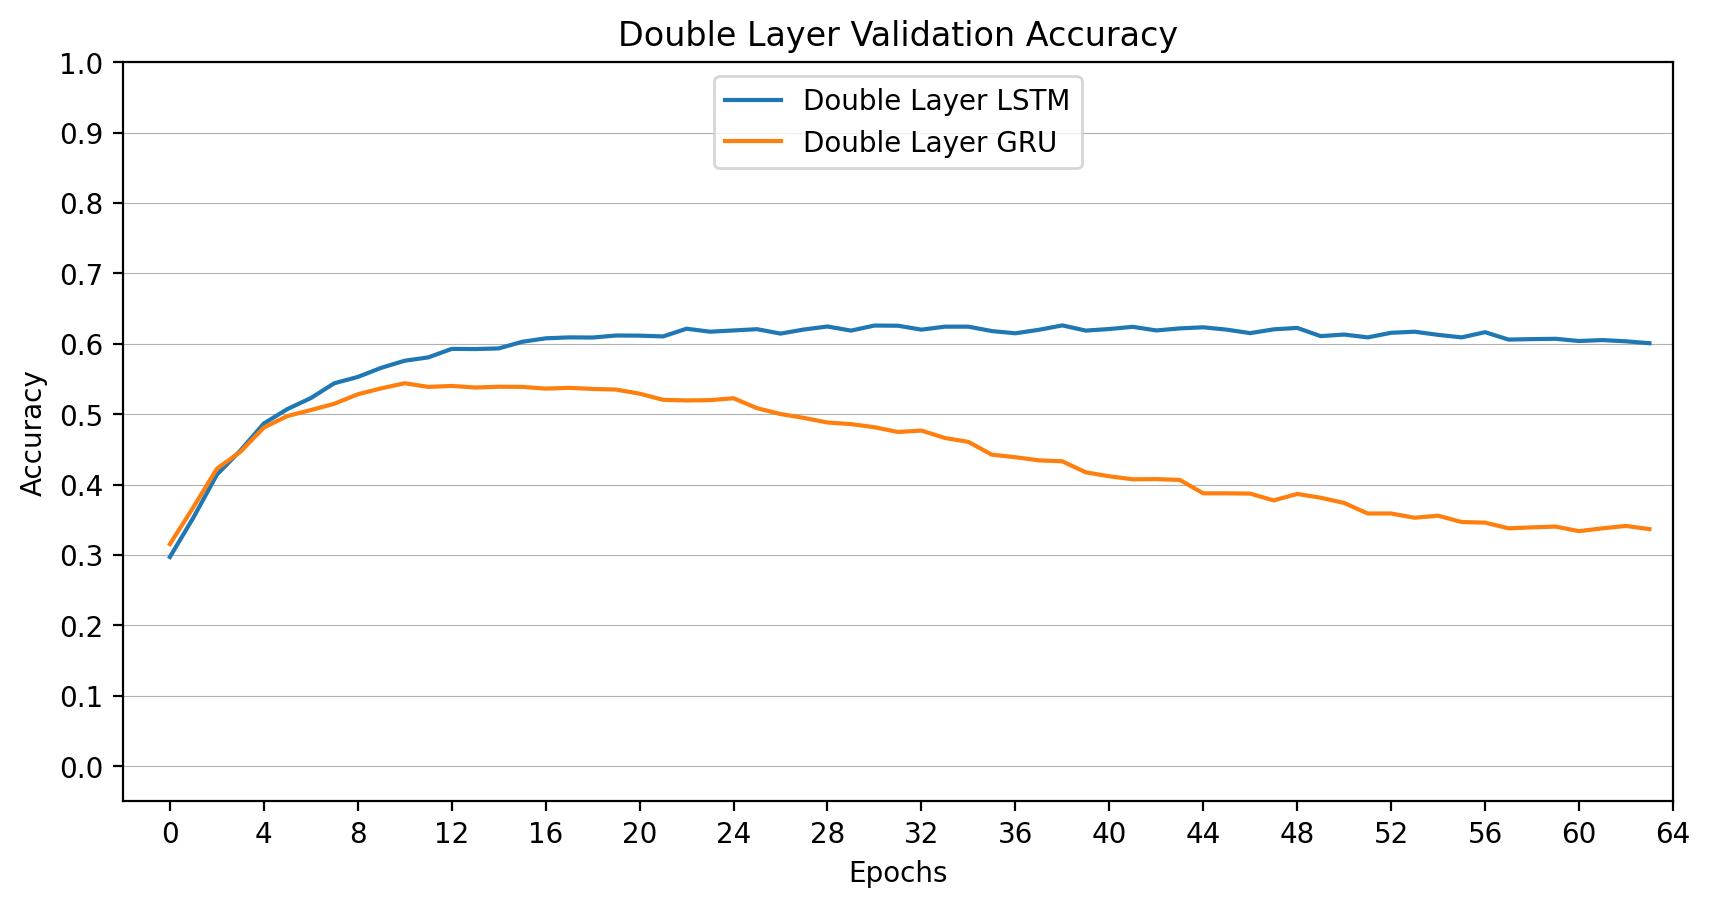

In [ ]:
plt.figure().set_figwidth(10)
plt.grid(axis = 'y', linewidth=0.4)
plt.plot(double_lstm_model.history.history['val_accuracy'])
plt.plot(double_gru_model.history.history['val_accuracy'])
plt.ylim([-0.05, 1])
plt.xlim([-2, 64])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(np.arange(0, 65, 4))
plt.title('Double Layer Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Double Layer LSTM', 'Double Layer GRU'], loc='upper center')
plt.show()

# Evaluator Model

In [ ]:
non_classical_path = "/content/gdrive/MyDrive/ug-data/non_classical/"
non_classical_midi_files = glob.glob(non_classical_path + '/*.mid', recursive=True)

In [ ]:
evl_input_sequences = []
evl_output_sequences = []
scaler = StandardScaler()

evl_seq_len = 1


for midi_file in tqdm(classical_midi_files):
  for trans in range(-5, 6):
    piano_roll = encode_midi(midi_file, trans)
    piano_roll = np.array(piano_roll)
    piano_roll = piano_roll.transpose()
    piano_roll = scaler.fit_transform(piano_roll)
    for i in range(0, piano_roll.shape[0] - evl_seq_len, evl_seq_len):
      evl_input_sequences.append(piano_roll[i: i+evl_seq_len])
      evl_output_sequences.append(1)



for midi_file in tqdm(non_classical_midi_files):
  for trans in range(-5, 6):
    piano_roll = encode_midi(midi_file, trans)
    piano_roll = np.array(piano_roll)
    piano_roll = piano_roll.transpose()
    piano_roll = scaler.fit_transform(piano_roll)
    for i in range(0, piano_roll.shape[0] - evl_seq_len, evl_seq_len):
      evl_input_sequences.append(piano_roll[i: i+evl_seq_len])
      evl_output_sequences.append(0)

  0%|          | 0/12 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2006 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(
  8%|▊         | 1/12 [00:15<02:47, 15.23s/it]/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2006 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(
 17%|█▋        | 2/12 [00:35<03:03, 18.39s/it]/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 1997 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(
 25%|██▌    

In [ ]:
len(evl_input_sequences)
len(evl_output_sequences)

418

In [ ]:
evl_batch_size = 32

In [ ]:
evl_input_sequences = np.array(evl_input_sequences)
evl_output_sequences = np.array(evl_output_sequences)

In [ ]:
evl_X_train, evl_X_test, evl_y_train, evl_y_test = train_test_split(
    evl_input_sequences, evl_output_sequences, test_size=0.1, random_state=42
)

In [ ]:
evl_loss = 'binary_crossentropy'

In [ ]:
evl_double_lstm = Sequential()
evl_double_lstm.add(LSTM(64, input_shape=(evl_seq_len, 88), return_sequences=True))
evl_double_lstm.add(Dropout(0.5))
evl_double_lstm.add(LSTM(64))
# evl_double_lstm.add(Dropout(0.5))
evl_double_lstm.add(Dense(1, activation='sigmoid'))


evl_double_lstm.compile(optimizer=RMSprop(learning_rate=0.0001), loss=evl_loss, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


In [ ]:
evl_double_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 1845, 64)          39168     
                                                                 
 dropout_2 (Dropout)         (None, 1845, 64)          0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 72257 (282.25 KB)
Trainable params: 72257 (282.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
evl_double_lstm_history = evl_double_lstm.fit(evl_X_train, evl_y_train,
                      epochs=200,
                      batch_size=evl_batch_size,
                      validation_data=(evl_X_test, evl_y_test))

Epoch 1/200
12/12 [==============================] - 6s 190ms/step - loss: 0.6816 - accuracy: 0.5559 - precision_2: 0.4061 - recall_2: 0.4926 - val_loss: 0.7000 - val_accuracy: 0.4286 - val_precision_2: 0.2500 - val_recall_2: 0.1667
Epoch 2/200
12/12 [==============================] - 2s 138ms/step - loss: 0.6652 - accuracy: 0.6277 - precision_2: 0.4821 - recall_2: 0.3971 - val_loss: 0.6946 - val_accuracy: 0.4524 - val_precision_2: 0.2222 - val_recall_2: 0.1111
Epoch 3/200
12/12 [==============================] - 2s 137ms/step - loss: 0.6584 - accuracy: 0.6356 - precision_2: 0.4954 - recall_2: 0.3971 - val_loss: 0.6900 - val_accuracy: 0.5238 - val_precision_2: 0.3333 - val_recall_2: 0.1111
Epoch 4/200
12/12 [==============================] - 2s 142ms/step - loss: 0.6428 - accuracy: 0.6729 - precision_2: 0.5747 - recall_2: 0.3676 - val_loss: 0.6852 - val_accuracy: 0.5238 - val_precision_2: 0.3333 - val_recall_2: 0.1111
Epoch 5/200
12/12 [==============================] - 2s 138ms/step -

In [ ]:
evl_double_lstm.save('/content/gdrive/MyDrive/ug_checkpoints/saved_model/evl_double_lstm')

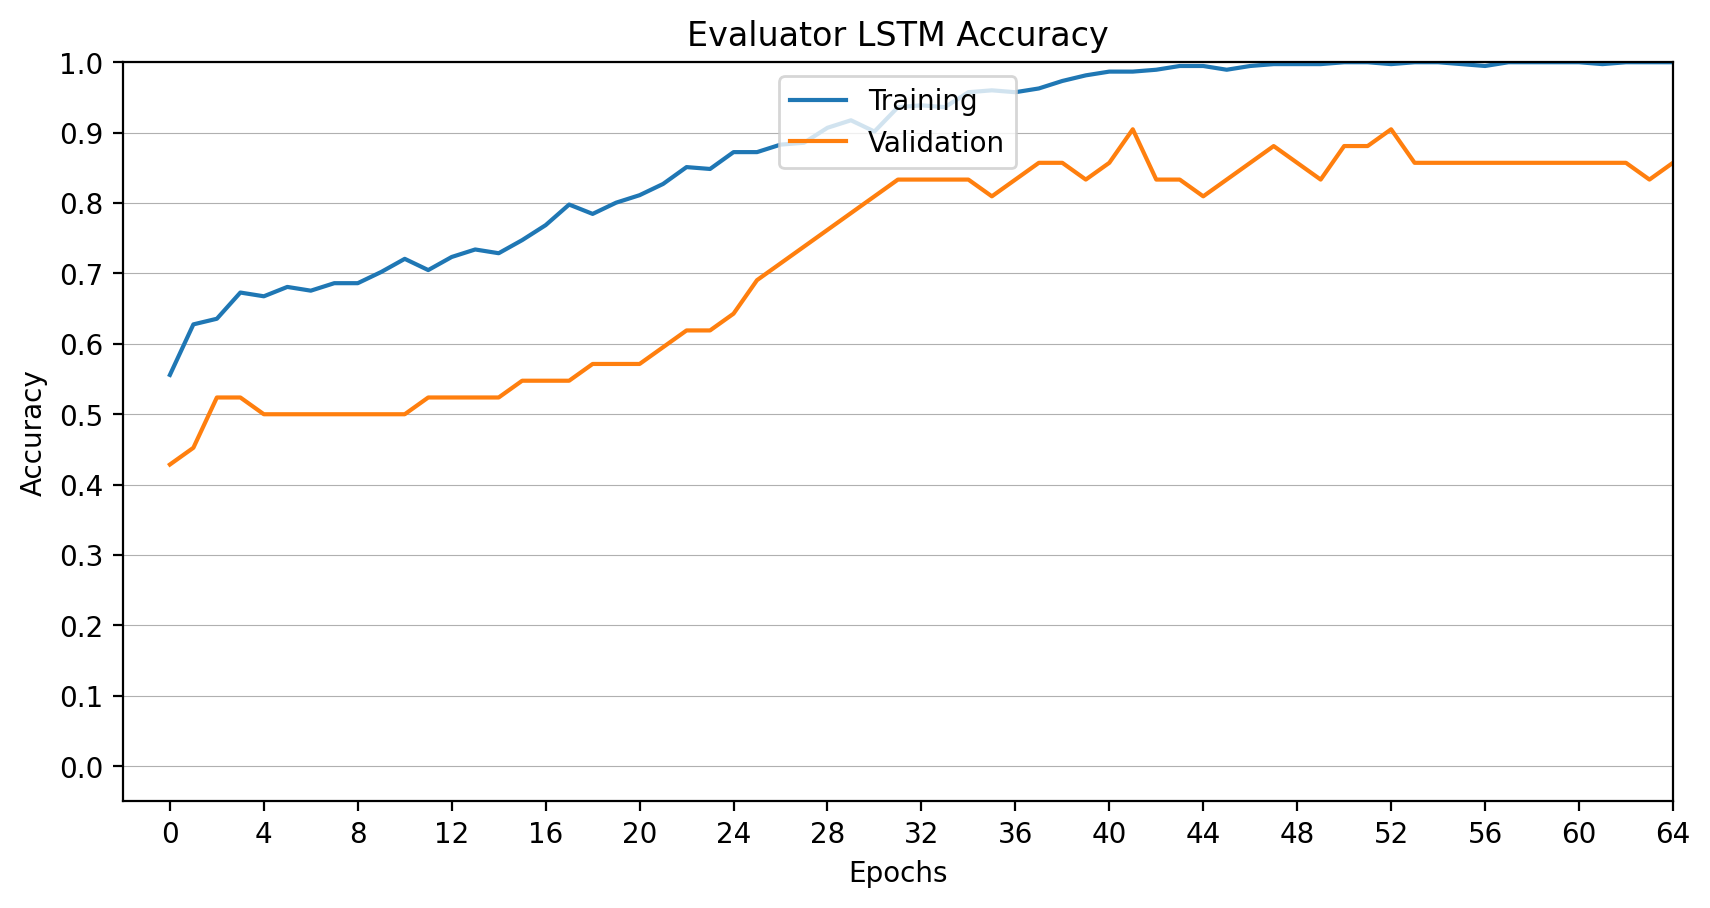

In [ ]:
plt.figure().set_figwidth(10)
plt.grid(axis = 'y', linewidth=0.4)
plt.plot(evl_double_lstm.history.history['accuracy'])
plt.plot(evl_double_lstm.history.history['val_accuracy'])
plt.ylim([-0.05, 1])
plt.xlim([-2, 64])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(np.arange(0, 65, 4))
plt.title('Evaluator LSTM Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='upper center')
plt.show()

In [ ]:
evl_double_gru = Sequential()
evl_double_gru.add(GRU(64, input_shape=(evl_seq_len, 88), return_sequences=True))
evl_double_gru.add(Dropout(0.5))
evl_double_gru.add(GRU(64))
evl_double_gru.add(Dropout(0.5))
evl_double_gru.add(Dense(1, activation='sigmoid'))


evl_double_gru.compile(optimizer=RMSprop(learning_rate=0.0001), loss=evl_loss, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


In [ ]:
evl_double_gru.summary()

In [ ]:
evl_double_gru_history = evl_double_gru.fit(evl_X_train, evl_y_train,
                      epochs=250,
                      batch_size=batch_size,
                      validation_data=(evl_X_test, evl_y_test))

In [ ]:
evl_double_gru.save('/content/gdrive/MyDrive/ug_checkpoints/saved_model/evl_double_gru')

In [ ]:
plt.figure().set_figwidth(10)
plt.grid(axis = 'y', linewidth=0.4)
plt.plot(evl_double_lstm.history.history['accuracy'])
plt.plot(evl_double_lstm.history.history['accuracy'])
plt.ylim([-0.05, 1])
plt.xlim([-2, 250])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(np.arange(0, 251, 25))
plt.title('Evaluator Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['LSTM', 'GRU'], loc='upper center')
plt.show()

In [ ]:
plt.figure().set_figwidth(10)
plt.grid(axis = 'y', linewidth=0.4)
plt.plot(evl_double_lstm.history.history['val_accuracy'])
plt.plot(evl_double_lstm.history.history['val_accuracy'])
plt.ylim([-0.05, 1])
plt.xlim([-2, 250])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(np.arange(0, 251, 25))
plt.title('Evaluator Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['LSTM', 'GRU'], loc='upper center')
plt.show()

In [ ]:
array_int32 = np.array([31784960, 69074944, 165871616])
array_int32.shape

(3,)

In [ ]:
for i in range(0, 5, 2):
  print(i)

0
2
4
